In [673]:
import time
from math import cos, pi, exp, e
import numpy
from numba import njit, jit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [674]:
y = 5
n_args_count = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 100  # максимальный вес рыбы

##Реализация алгоритма

In [675]:
# @njit()
# @jit(nopython=True)
def main_function():
    step_ind = list()
    step_vol = list()
    p_qbest_list = list()  # массив p_qbest в разные моменты поколений
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    step_ind.append(1)
    step_vol.append(1)
    w = list()
    w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    P = list()  # Начальная популяция
    P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list.append(p_qbest)

    f_t = list()
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t.append(f_I)

    # значение функции для каждого агента
    F = [numpy.array(f_t)]
    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        step_vol.append(step_vol[0] * exp(-y * t / iter_max))

        P.append(numpy.copy(P[t - 1]))
        w.append(numpy.copy(w[t - 1]))
        F.append(numpy.zeros(number_of_agents))
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]):
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list.append(p_qbest)

    return p_qbest_list

In [676]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [677]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    dispersion = numpy.sqrt(numpy.var(best_values))
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - dispersion,
                     numpy.zeros(10) + dispersion,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [678]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [679]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [680]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.97741996 0.01649258]
The function value of pqbest:		1.1097386447658337
Algorithm running time:			1.2047216892242432 s


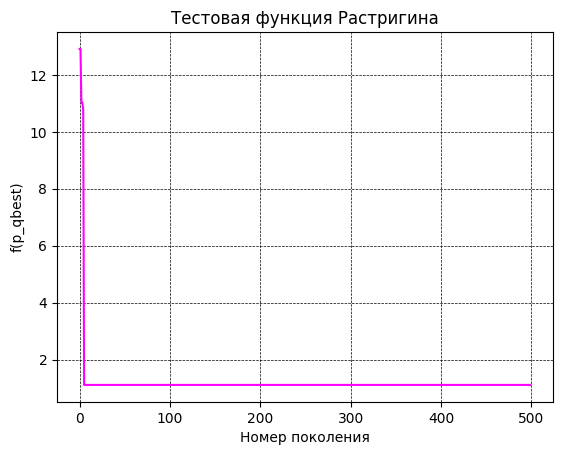

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.908942   0.03463729]
The function value of pqbest:		2.655788236086007
Algorithm running time:			1.15378737449646 s


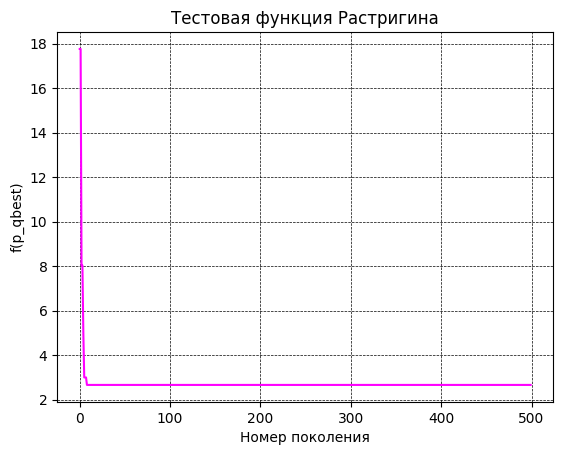

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[0.00979641 0.09665513]
The function value of pqbest:		1.8164701618792023
Algorithm running time:			1.1354446411132812 s


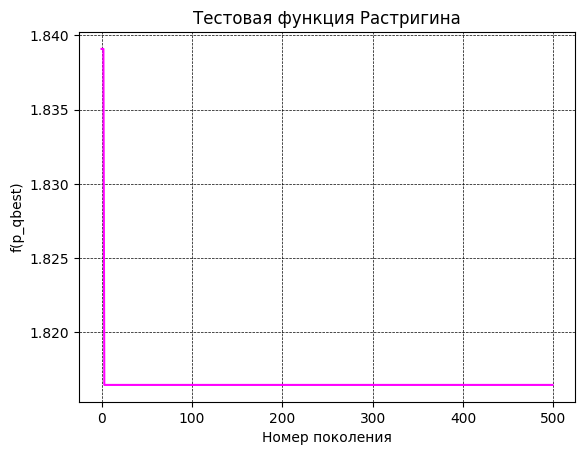

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.04981031 0.00472607]
The function value of pqbest:		0.4926704875196819
Algorithm running time:			1.204967737197876 s


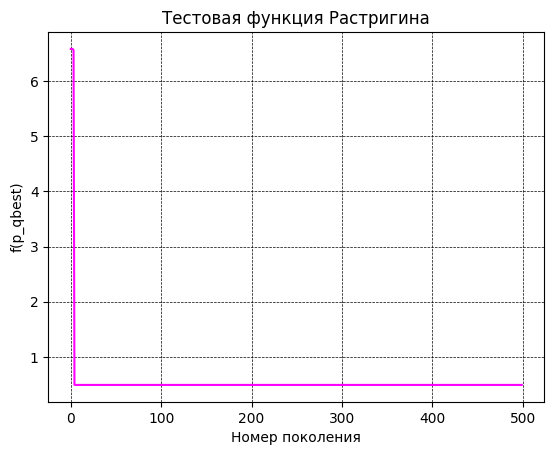

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.11509603 -0.0437544 ]
The function value of pqbest:		2.8935650723078723
Algorithm running time:			1.2058959007263184 s


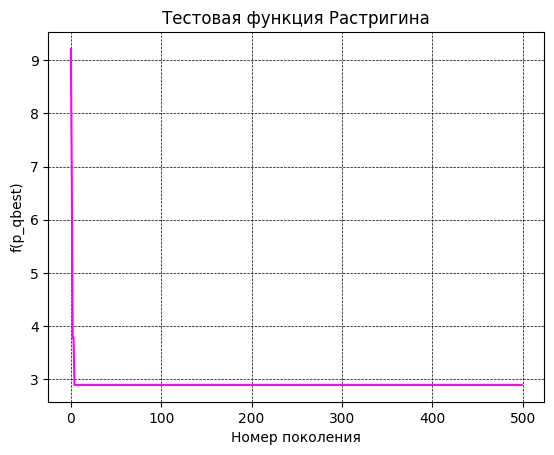

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.01521505 0.03722244]
The function value of pqbest:		0.3195224248314119
Algorithm running time:			1.172454595565796 s


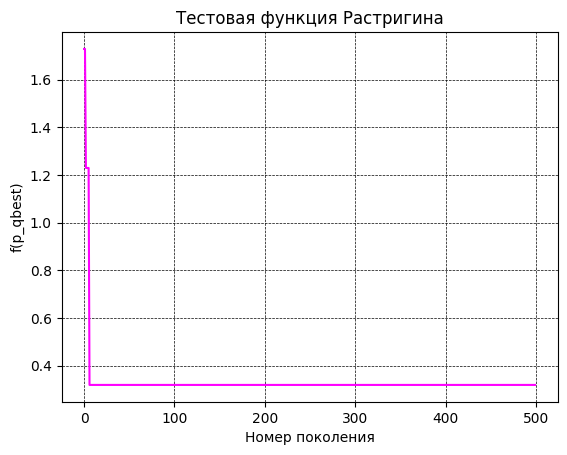

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.05916498  0.08400834]
The function value of pqbest:		2.0546368784457343
Algorithm running time:			1.1570944786071777 s


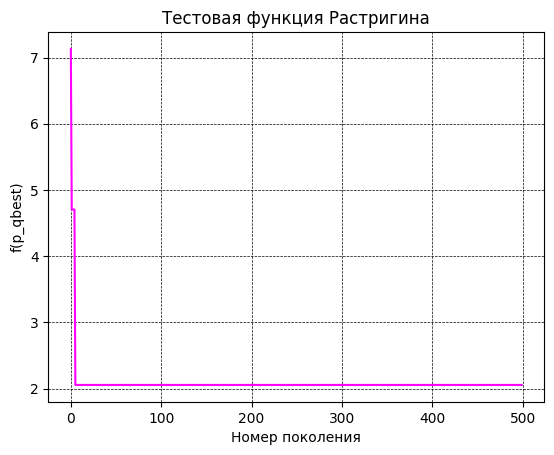

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.07399808 -0.0477296 ]
The function value of pqbest:		1.5156073296026804
Algorithm running time:			1.171102523803711 s


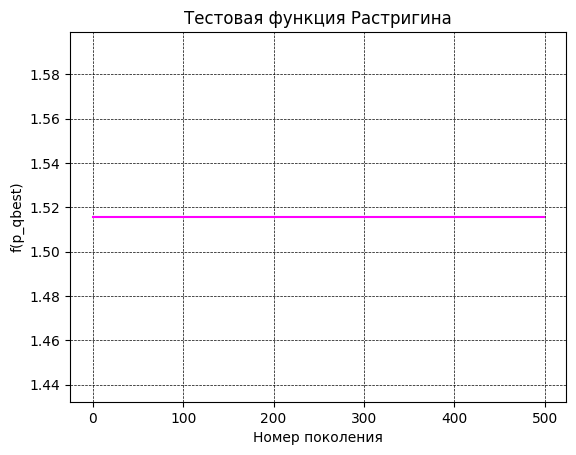

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 1.03134468 -1.04983454]
The function value of pqbest:		2.8453612904728054
Algorithm running time:			1.1319129467010498 s


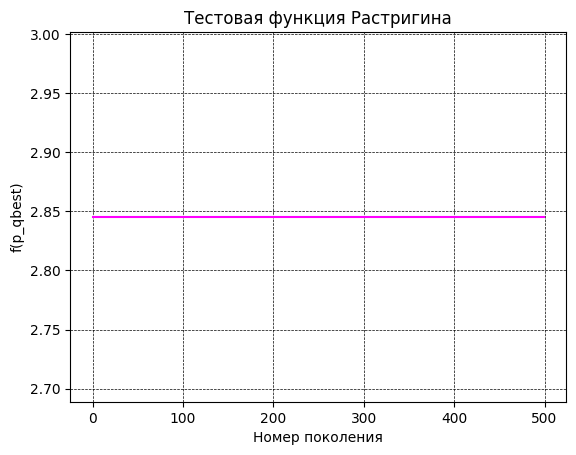

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.05012737 -1.03951248]
The function value of pqbest:		1.881605789754893
Algorithm running time:			1.1132333278656006 s


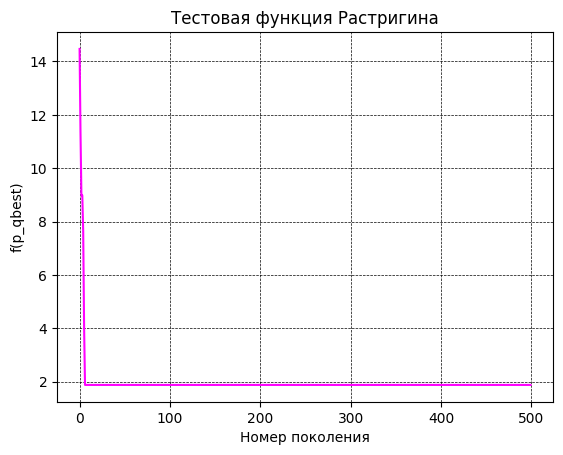

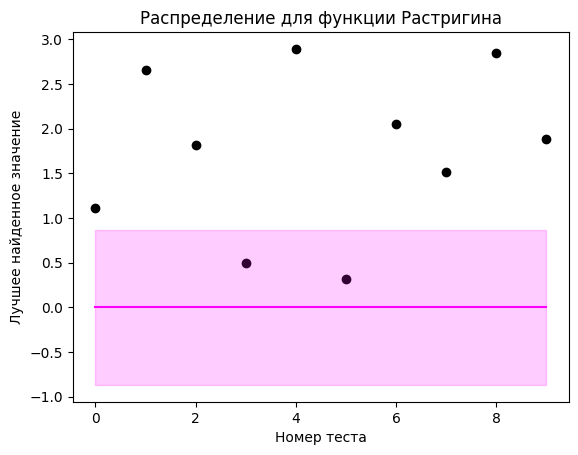

In [681]:
start_test("Растригина")

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [682]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * (0.5 * (x[0] ** 2 + x[1] ** 2)) ** 0.5) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [683]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5, 5, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.08581158  0.14213985]
The function value of pqbest:		1.0810956912218117
Algorithm running time:			1.090942621231079 s


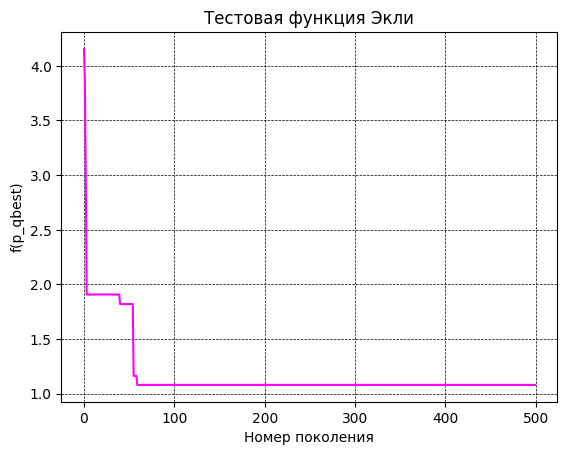

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.02678824 -0.13600078]
The function value of pqbest:		0.8332400470889212
Algorithm running time:			1.0858285427093506 s


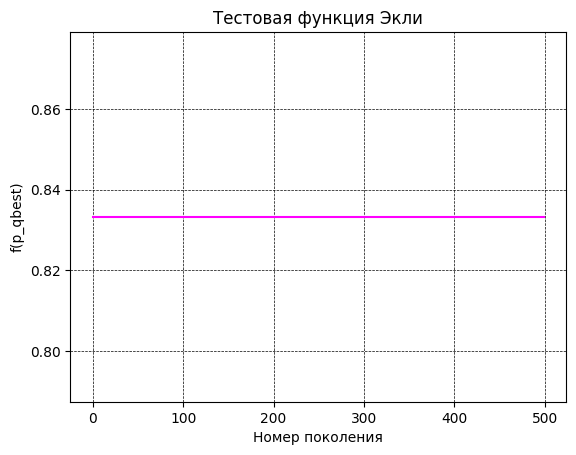

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.10396409  0.14951266]
The function value of pqbest:		1.2286853448917263
Algorithm running time:			1.0960052013397217 s


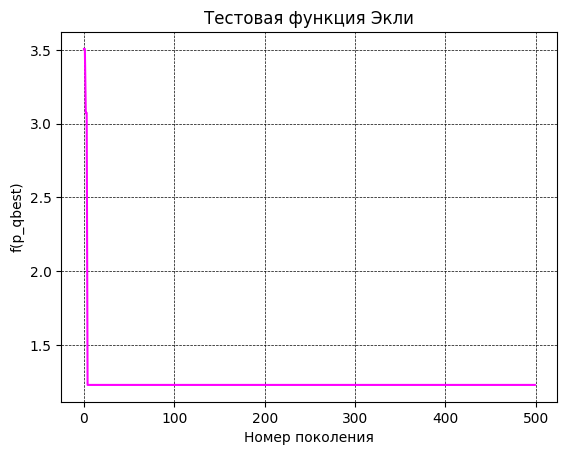

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.01284945  0.16381582]
The function value of pqbest:		1.047761870725271
Algorithm running time:			1.0846631526947021 s


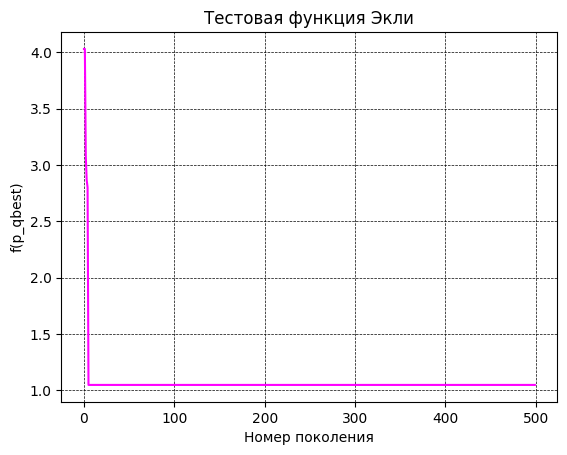

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.06041628  0.0274623 ]
The function value of pqbest:		0.3012904087885069
Algorithm running time:			1.0834803581237793 s


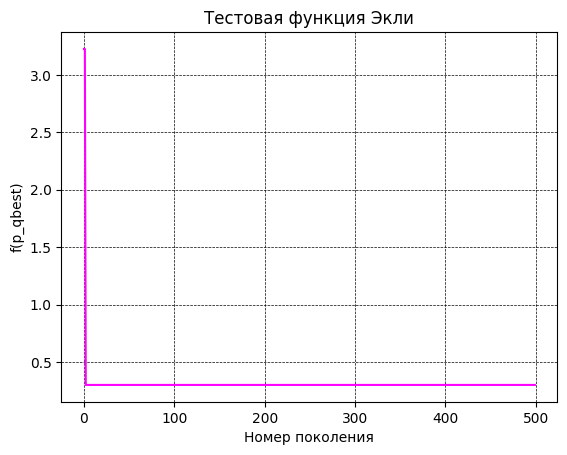

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.07303686 0.11952845]
The function value of pqbest:		0.8541899094067205
Algorithm running time:			1.0958197116851807 s


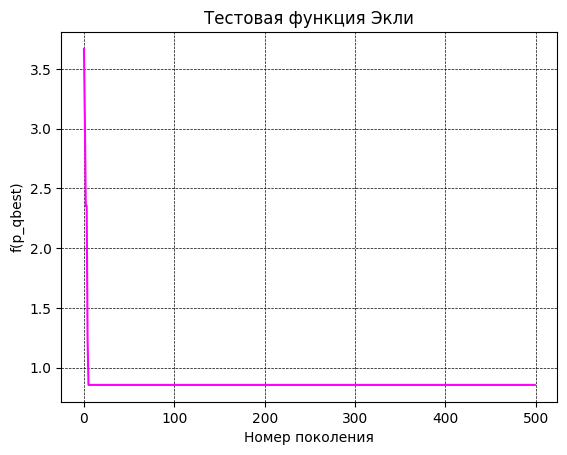

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.08217966 -0.0330155 ]
The function value of pqbest:		0.44763119565051923
Algorithm running time:			1.099592685699463 s


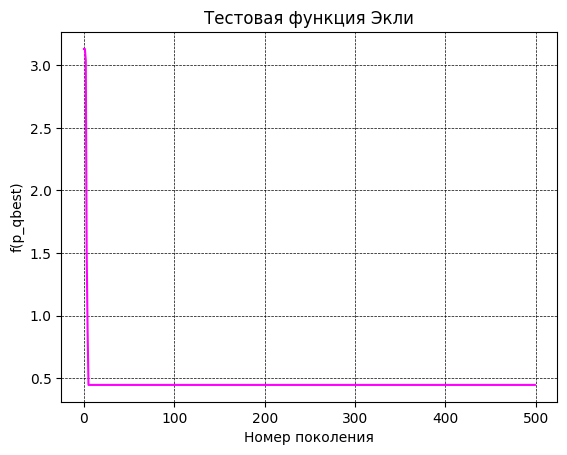

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.03526142 -0.01151783]
The function value of pqbest:		0.14117648411964723
Algorithm running time:			1.0935051441192627 s


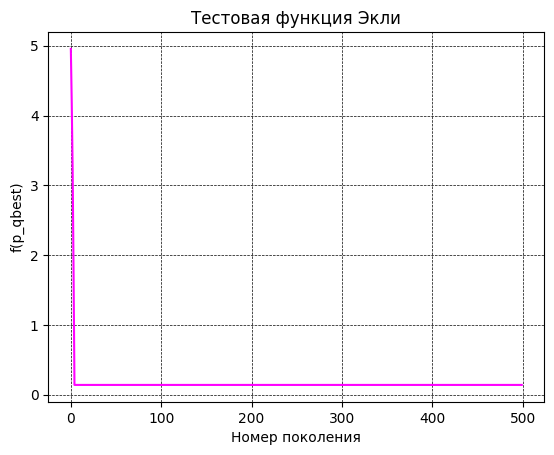

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.2330751  -0.19644066]
The function value of pqbest:		2.318309611043812
Algorithm running time:			1.0733118057250977 s


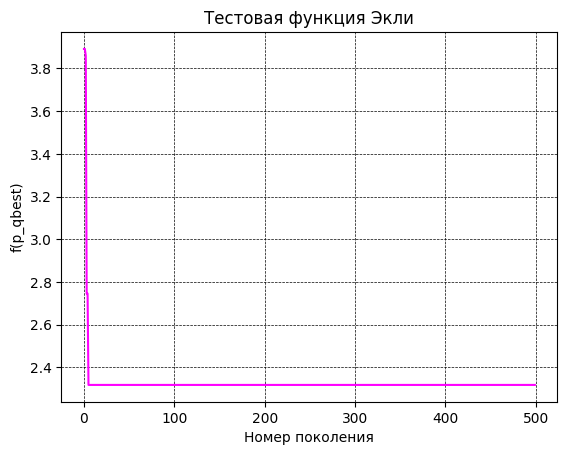

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.05769342 -0.00447286]
The function value of pqbest:		0.2504288147512419
Algorithm running time:			1.1639988422393799 s


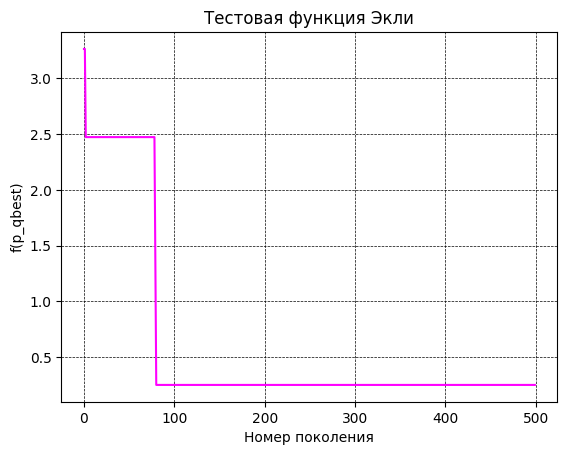

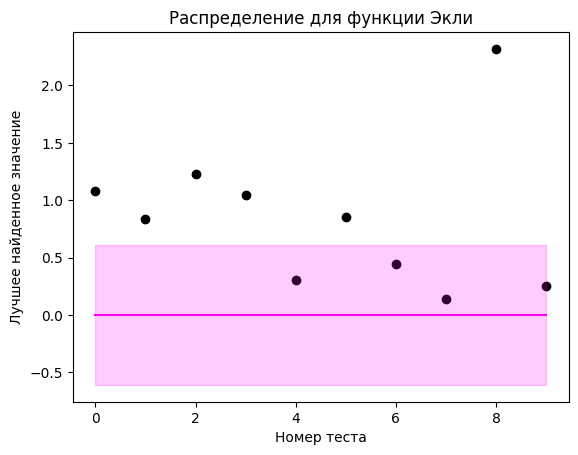

In [684]:
start_test("Экли")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [685]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i ** 2
    return result

##Генерация начальных агентов

In [686]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-32767, 32767, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[3350.25470244 6473.01500543]
The function value of pqbest:		53124129.83171023
Algorithm running time:			1.1072757244110107 s


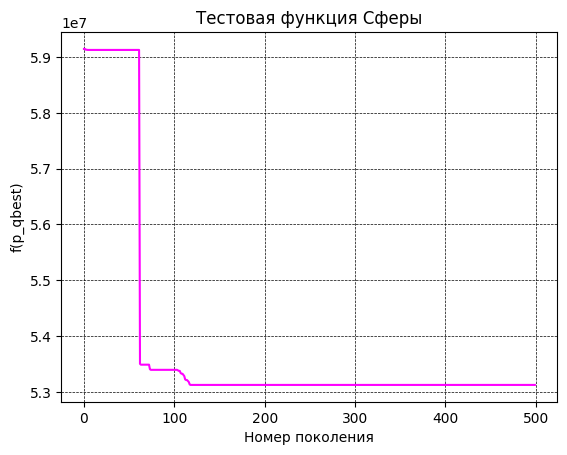

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[2450.81345652 1116.23312747]
The function value of pqbest:		7252462.993508501
Algorithm running time:			1.0473895072937012 s


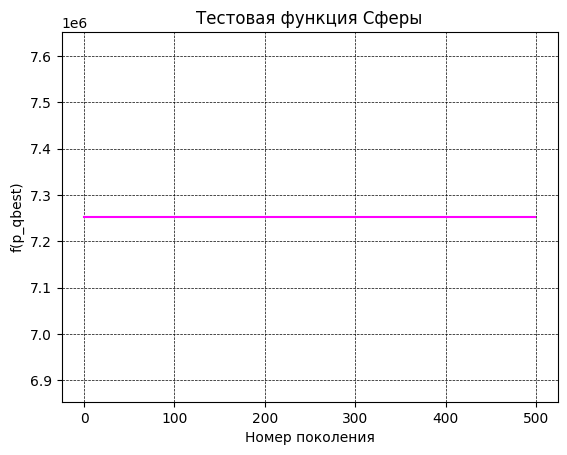

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[3297.50623207  620.68578816]
The function value of pqbest:		11258798.198142612
Algorithm running time:			1.053713083267212 s


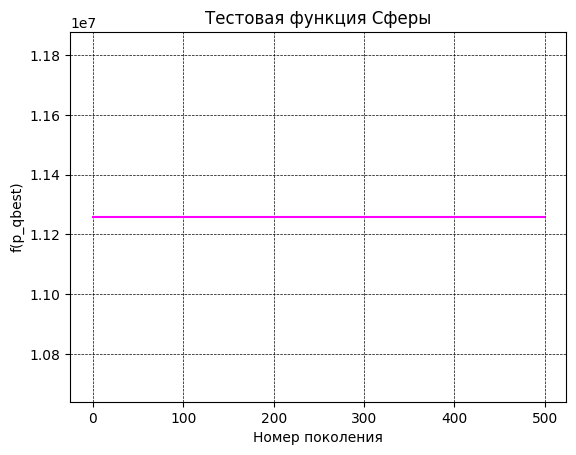

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[2626.59383706 2511.9121757 ]
The function value of pqbest:		13208697.963272102
Algorithm running time:			1.1288120746612549 s


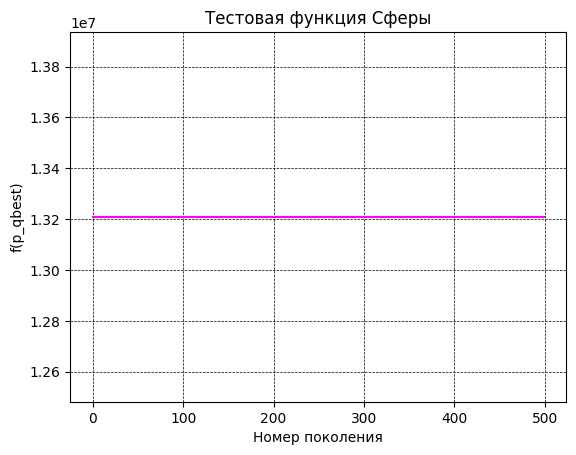

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-8624.51329504   590.08675016]
The function value of pqbest:		74730431.94907427
Algorithm running time:			1.0491738319396973 s


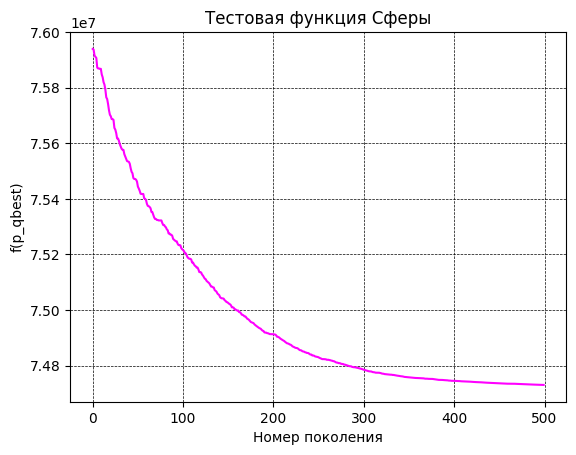

In [ ]:
start_test("Сферы")
